# Load dataset

In [ ]:
from keras.datasets.mnist import load_data
from tensorflow.keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = load_data()
# normalize data
x_train = x_train.reshape(-1,784)/255
x_test = x_test.reshape(-1,784)/255
# make one-hot target
train_label = y_train.copy()
test_label = y_test.copy()
y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)

11493376/11490434 [==============================] - 0s 0us/step


# Create VAE model
In this model only dense layers are used for encoder and decoder part. For sampling noise,Lambda layer is used. KL loss and reconstruction loss is defined in the following cell. 

In [ ]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.objectives import binary_crossentropy
from tensorflow.keras.utils import plot_model
import numpy as np

batch_size = 200
latent_dim = 2

# custom layer for sampling
def sampling(inputs):
    mean, var = inputs
    eps = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=1)
    return mean + K.exp(var) * eps

# encoder model using dense layers
enc_input = Input(shape=(784))
dense = Dense(500,activation='relu')(enc_input)

# mean and variance
mean = Dense(latent_dim,activation='linear',name='mean')(dense)
var = Dense(latent_dim,activation='linear',name='var')(dense)

# sampling layer
latent = Lambda(sampling,name='Latent')([mean, var])
encoder = Model(enc_input,latent)
encoder._name = 'encoder'

# decoder model using dense layers
dec_input = Input(shape=(2))
dense = Dense(500, activation='relu')(dec_input)
dec_output = Dense(784, activation='sigmoid',name='Decoder')(dense)
decoder = Model(dec_input,dec_output)
decoder._name = 'decoder'
vae_output = decoder(encoder(enc_input))
vae = Model(enc_input,vae_output)
# plot_model(vae,expand_nested=True,show_shapes=True)

# vae loss function
rec_loss = binary_crossentropy(enc_input,vae_output) *784
kl_loss = 0.5 * K.sum(K.square(mean) + K.exp(var) - var - 1,axis=-1)
vae_loss = rec_loss + kl_loss

# compile vae model
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
Loss = []
Val_Loss = []
latent = []
# fit model in 50 epochs in for loop for checking model progress
for i in range(5):
  history = vae.fit(x_train,x_train,epochs=4,
          batch_size=batch_size,
          validation_data=(x_test, x_test))
  z = encoder.predict(x_test,batch_size=batch_size)
  # appending results
  latent.append(z)
  Loss.append(history.history['loss'])
  Val_Loss.append(history.history['val_loss'])

Epoch 1/4
300/300 [==============================] - 1s 4ms/step - loss: 264.3096 - val_loss: 186.6107
Epoch 2/4
300/300 [==============================] - 1s 3ms/step - loss: 181.1787 - val_loss: 171.5998
Epoch 3/4
300/300 [==============================] - 1s 3ms/step - loss: 170.3012 - val_loss: 166.8751
Epoch 4/4
300/300 [==============================] - 1s 3ms/step - loss: 166.2126 - val_loss: 164.4887
Epoch 1/4
300/300 [==============================] - 1s 3ms/step - loss: 163.9085 - val_loss: 162.8170
Epoch 2/4
300/300 [==============================] - 1s 3ms/step - loss: 162.4890 - val_loss: 161.8186
Epoch 3/4
300/300 [==============================] - 1s 3ms/step - loss: 161.3651 - val_loss: 160.6547
Epoch 4/4
300/300 [==============================] - 1s 3ms/step - loss: 160.3420 - val_loss: 159.8242
Epoch 1/4
300/300 [==============================] - 1s 3ms/step - loss: 159.4892 - val_loss: 159.2982
Epoch 2/4
300/300 [==============================] - 1s 3ms/step - loss: 

# Plot losses (VAE)

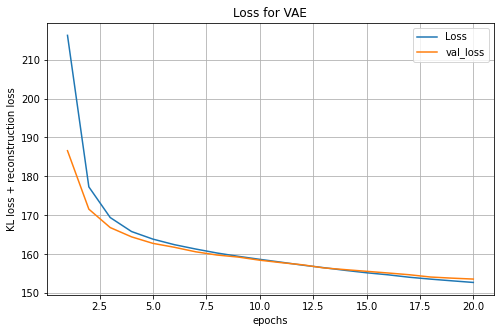

In [ ]:
import matplotlib.pyplot as plt
Val = np.array(Val_Loss)
Loss = np.array(Loss)
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,21),Loss.reshape(20),label='Loss')
plt.plot(np.arange(1,21),Val.reshape(20),label='val_loss')
plt.title('Loss for VAE')
plt.ylabel('KL loss + reconstruction loss')
plt.xlabel('epochs')
plt.legend()
plt.grid()

# Showing latent space (VAE)

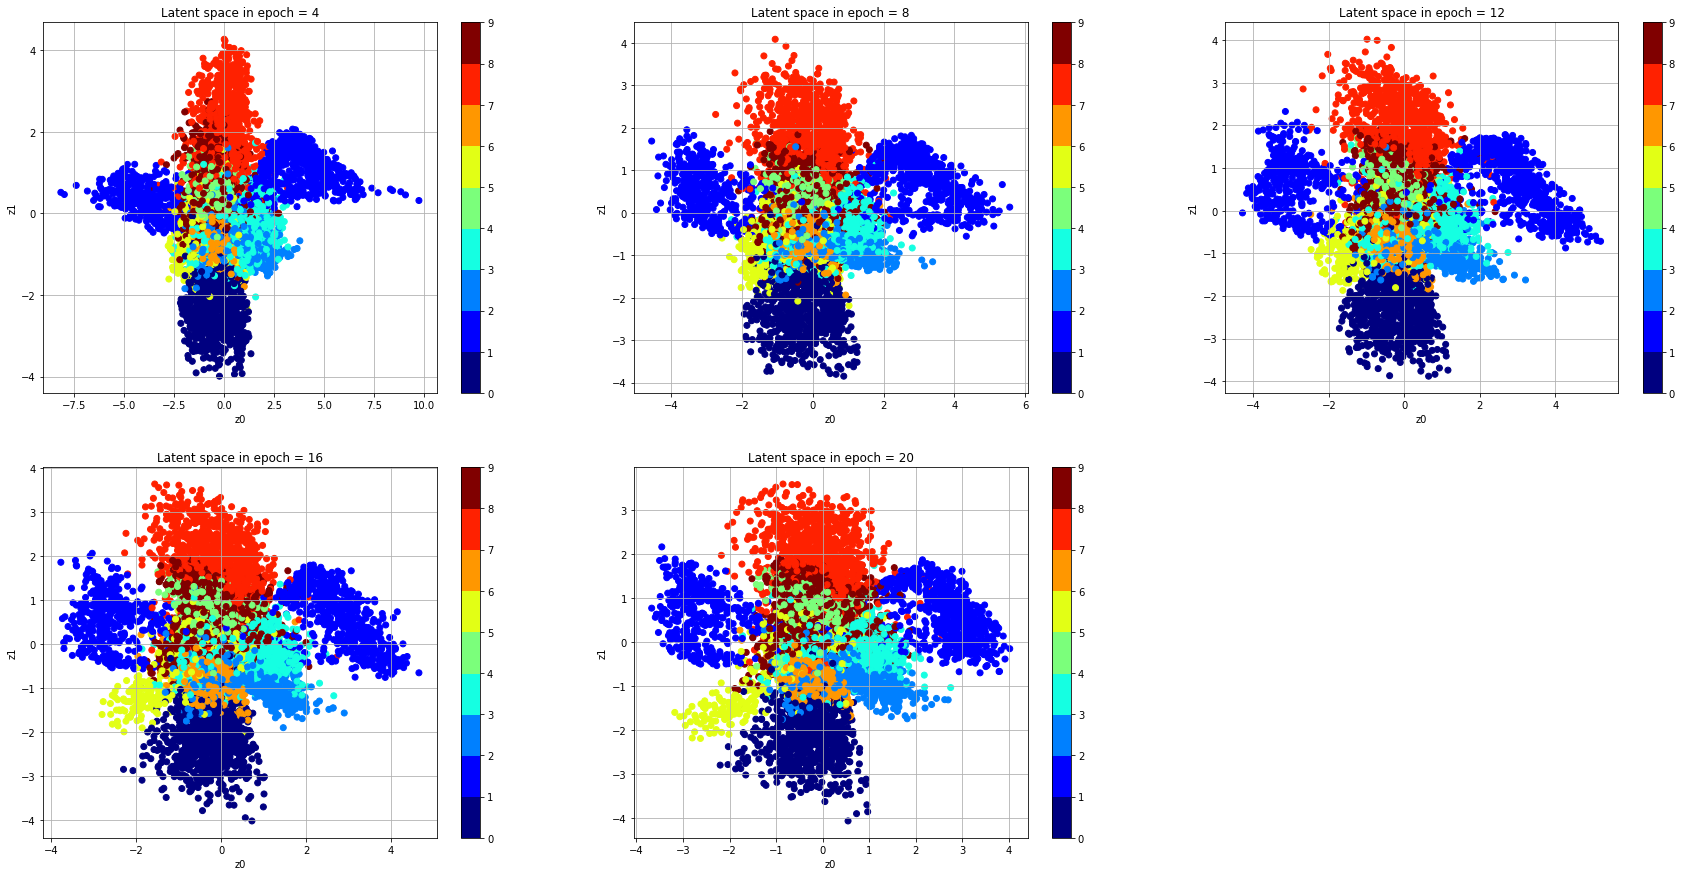

In [ ]:
import matplotlib.pyplot as plt
latent_space = np.array(latent)
plt.figure(figsize=(30, 15))
for i in range(5):
  plt.subplot(2,3,i+1)
  plt.scatter(latent_space[i,:,0],latent_space[i,:,1],c=test_label,
              cmap=plt.cm.get_cmap('jet', 9))
  plt.xlabel('z0')
  plt.ylabel('z1')
  plt.title('Latent space in epoch = %d'%(4*i+4))
  plt.colorbar()
  plt.grid()

# Showing grid images (VAE)
In the following code show_grid_images function is defind. Intervals for z0 nd z1 in latent space are given to this function.

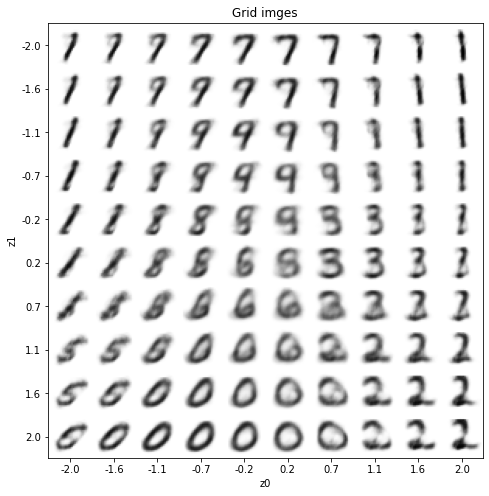

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_grid_images(z0_range,z1_range,grid_size):
  grid = np.zeros((28*grid_size,28*grid_size))
  # select z0 nd z1 intervals
  z0 = np.linspace(z0_range[0],z0_range[1],grid_size)
  z1 = np.linspace(z1_range[0],z1_range[1],grid_size)
  #create grid
  for i , Z1 in enumerate(z1):
    for j , Z0 in enumerate(z0):
      z = np.array([Z0,Z1]).reshape(1,2)
      img = decoder.predict(z).reshape(28,28)
      grid[28*(grid_size-i-1):28*(grid_size-i),28*j:28*(j+1)] = img
  # show grid with correct axes
  axis_range = np.arange(14,28*grid_size,28)
  xticks = np.round(z0,1)
  yticks = np.round(z1,1)
  plt.figure(figsize=(8,8))
  plt.imshow(grid,'gray_r')
  plt.xticks(axis_range,xticks)
  plt.yticks(axis_range,yticks)
  plt.xlabel('z0')
  plt.ylabel('z1')
  plt.title('Grid imges')
  plt.savefig('vae_grid.jpg',quality=95,dpi=250,bbpox_inches='tight')

show_grid_images([-2,2],[-2,2],10)

# Create CVAE model
This model is similar to VAE model but label is added to encoder and decoder as an additional input.

In [ ]:
from keras.layers import Concatenate 
batch_size = 200
latent_dim = 2

# custom layer for sampling
def sampling(inputs):
    mean, var = inputs
    eps = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=1)
    return mean + K.exp(var) * eps

# encoder model
img = Input(shape=(784))
label = Input(shape=(10),name='Label')
enc_input = Concatenate()([img,label])
dense = Dense(500,activation='relu')(enc_input)
mean = Dense(latent_dim,activation='linear',name='mean')(dense)
var = Dense(latent_dim,activation='linear',name='var')(dense)
latent = Lambda(sampling,name='Latent')([mean, var])
encoder = Model([img,label],latent)
encoder._name = 'encoder'

# decoder model
latent = Input(shape=(2))
dec_input = Concatenate()([latent,label])
dense = Dense(500, activation='relu')(dec_input)
dec_output = Dense(784, activation='sigmoid',name='Decoder')(dense)
decoder = Model([latent,label],dec_output)
decoder._name = 'decoder'

# cvae model
enc_output = encoder([img,label])
cvae_output = decoder([enc_output,label])
cvae = Model([img,label],cvae_output)
# cvae loss function
rec_loss = binary_crossentropy(img,cvae_output) *784
kl_loss = 0.5 * K.sum(K.square(mean) + K.exp(var) - var - 1,axis=-1)
cvae_loss = rec_loss + kl_loss

# compile and fit cvae model
cvae.add_loss(cvae_loss)
cvae.compile(optimizer='adam')
history = cvae.fit([x_train,y_train],x_train,epochs=30,
                   batch_size=batch_size,
                   validation_data=([x_test,y_test], x_test))

Epoch 1/30
300/300 [==============================] - 1s 3ms/step - loss: 247.7339 - val_loss: 151.2764
Epoch 2/30
300/300 [==============================] - 1s 3ms/step - loss: 148.0885 - val_loss: 141.3106
Epoch 3/30
300/300 [==============================] - 1s 3ms/step - loss: 140.7226 - val_loss: 138.2707
Epoch 4/30
300/300 [==============================] - 1s 3ms/step - loss: 138.0614 - val_loss: 136.7877
Epoch 5/30
300/300 [==============================] - 1s 3ms/step - loss: 136.6400 - val_loss: 135.5555
Epoch 6/30
300/300 [==============================] - 1s 3ms/step - loss: 135.4913 - val_loss: 134.7393
Epoch 7/30
300/300 [==============================] - 1s 3ms/step - loss: 134.3679 - val_loss: 134.1116
Epoch 8/30
300/300 [==============================] - 1s 3ms/step - loss: 133.4241 - val_loss: 133.2888
Epoch 9/30
300/300 [==============================] - 1s 3ms/step - loss: 132.9336 - val_loss: 132.7042
Epoch 10/30
300/300 [==============================] - 1s 3ms/st

# Plot loss (CVAE)

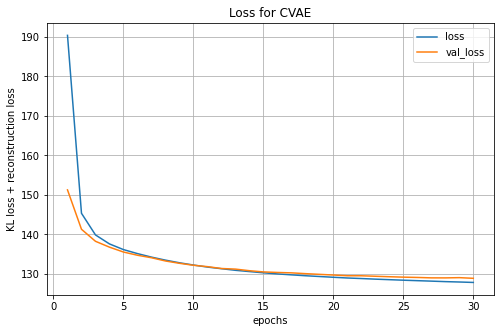

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,31),history.history['loss'],label='loss')
plt.plot(np.arange(1,31),history.history['val_loss'],label='val_loss')
plt.title('Loss for CVAE')
plt.ylabel('KL loss + reconstruction loss')
plt.xlabel('epochs')
plt.legend()
plt.grid()

# Showing latent space (CVAE)

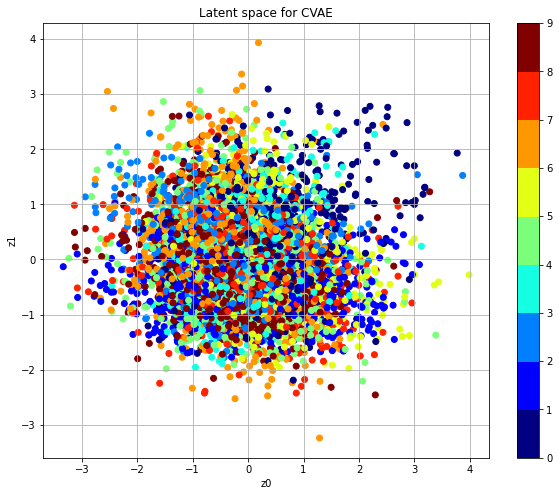

In [ ]:
import matplotlib.pyplot as plt
latent_space = encoder.predict([x_test,y_test],batch_size=batch_size)
plt.figure(figsize=(10, 8))
plt.scatter(latent_space[:,0],latent_space[:,1],c=test_label,
            cmap=plt.cm.get_cmap('jet', 9))
plt.title('Latent space for CVAE')
plt.xlabel('z0')
plt.ylabel('z1')
plt.colorbar()
plt.grid()

# Showing grid images (CVAE)
show_grid_images function is defined for CVAE model. The function is similar to the show_grid_images used in VAE part but it gets digit label as an argument.

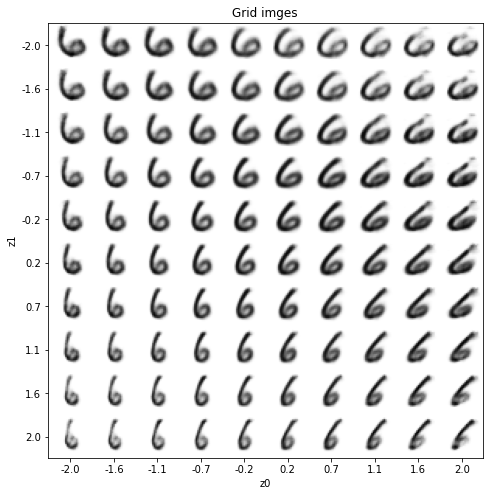

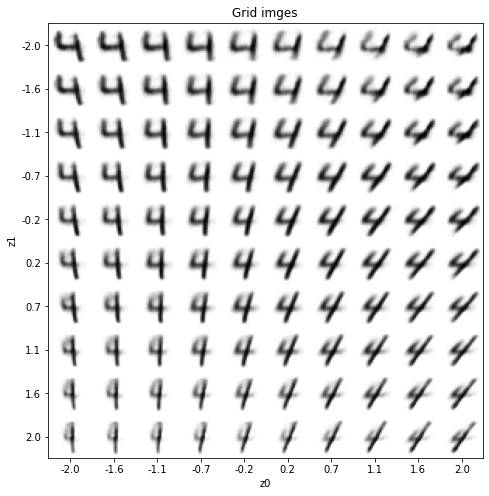

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_grid_images(z0_range,z1_range,digit,grid_size):
  label = np.zeros([1,10])
  label[0,digit] = 1
  grid = np.zeros((28*grid_size,28*grid_size))
  # select z0 nd z1 intervals
  z0 = np.linspace(z0_range[0],z0_range[1],grid_size)
  z1 = np.linspace(z1_range[0],z1_range[1],grid_size)
  #create grid
  for i , Z1 in enumerate(z1):
    for j , Z0 in enumerate(z0):
      z = np.array([Z0,Z1]).reshape(1,2)
      img = decoder.predict([z,label]).reshape(28,28)
      grid[28*(grid_size-i-1):28*(grid_size-i),28*j:28*(j+1)] = img
  # show grid with correct axes
  axis_range = np.arange(14,28*grid_size,28)
  xticks = np.round(z0,1)
  yticks = np.round(z1,1)
  plt.figure(figsize=(8,8))
  plt.imshow(grid,'gray_r')
  plt.xticks(axis_range,xticks)
  plt.yticks(axis_range,yticks)
  plt.xlabel('z0')
  plt.ylabel('z1')
  plt.title('Grid imges')
  name = 'cvae_grid_'+str(digit)+'.jpg'

show_grid_images([-2,2],[-2,2],6,10)
show_grid_images([-2,2],[-2,2],4,10)